# A Jupyter Notebook to simulate synthetic earthquake point process data

### This notebook will guide you through the process of generating some synthetic earthquake data. The aim is to increase your familiarity with many of the empirical rules of earthqukae seismicity, and provide you with some experiences of how to work with these in a computational environment.

### The fundamental 'laws' of empirical seismicity are:
#### (1) The Gutenberg-Richter relation
#### (2) The (modified) Omori law
#### (3) A power law dependence of aftershock productivity on mainshock magnitude

#### When combined with a Poisson rate of background earthquakes, these laws constitute the 'ETAS' model for seismicty, the 'null hypothesis' for tectonic earthquake occurrence.

### The aim of this notebook is to guide you through different steps required to simulate data with these underlying properties.

In [21]:
import matplotlib.pyplot as plt
import numpy as np

## Import necessary functions/libraries

#### You'll need to add new functions here as your code develops

In [22]:
from scipy.stats import expon, poisson, uniform
from numpy import arange, histogram, log10, exp, round, cumsum, max

# 1. Background Poisson seismicity

#### We understand that background seismicity involves independent events, with magnitudes drawn at random from a Gutenberg-Richter distribution. The implication is that inter-event times follow an exponenitial distribution, and that rates locall follow a Poisson distribution.

### Begin by creating an array with 1000 days of earthquakes, with a mean rate of 10 earthquakes per day, and with exponential interevent times. Use the scipy.stats 'expon' function - rvs will give you your random variates. If you then do a cumulate sum of these interevent times, you will get a list of actual times, with Poisson process properties. You'll need to check the length is >1000 or <1000 days, and correct accordingly.

In [23]:
rate = 10
duration = 1000
data1 = expon.rvs(scale=1./rate, size=rate*duration)
times1 = cumsum(data1)

while max(times1) < 1000:
    times1 = hstack((times1, max(times1) + expon.rvs(scale=1./rate, size=1)))
    
times1 = times1[times1<=1000]

### Now plot a graph of daily earthquake rates and total earthquakes as a function of time

In [24]:
days = arange(1001)
day_counts, bes = histogram(times1, days)

(0.0, 1000.0)

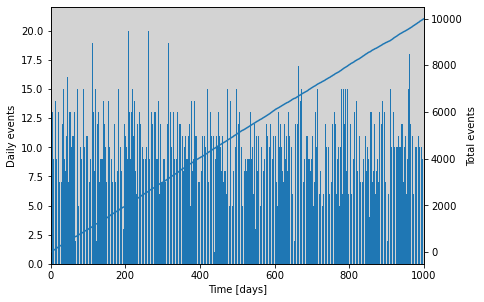

In [25]:
fig1 = plt.figure(figsize=(17/2.54,12/2.54))
ax1 = fig1.add_subplot(111, facecolor='lightgrey')
ax1.bar(days[:-1], day_counts, align='center')
ax1.set_ylabel('Daily events')
ax1.set_xlim(0, 1000)
ax2 = ax1.twinx()
ax2.plot(times1, arange(len(times1)))
ax1.set_xlabel('Time [days]')
ax2.set_ylabel('Total events')
ax2.set_xlim(0, 1000)

### Plot a histogram of the daily event rates, and check it fits a Poisson distribution

### Use the probability mass function (pmf) of the scipy.stats poisson function poisson.pmf(...)

In [26]:
ders = arange(0, max(day_counts)+1)
der_counts, bes = histogram(day_counts, ders)

Text(0.5, 0, 'Daily event rate')

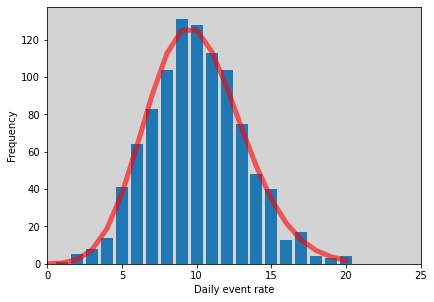

In [27]:
fig2 = plt.figure(figsize=(17/2.54,12/2.54))
ax1 = fig2.add_subplot(111, facecolor='lightgrey')
ax1.bar(ders[:-1], der_counts, align='center')
ax1.plot(ders[:-1], poisson.pmf(ders[:-1], 10)*1000, 'r-', lw=5, alpha=0.6)
ax1.set_ylabel('Frequency')
ax1.set_xlim(0, 25)
ax1.set_xlabel('Daily event rate')

### Now we need to think about earthquake magnitudes - let's give each of our background earthquakes a magnitude chosen at random from the Gutenberg-Richter distribution

### Use a typical b-value, and a Minimum magnitude of 2.0. Round your magnitudes to a typical precision of 1 decimal place
### What scaling do you need between b and the scale parameter?

In [28]:
b = 1.0
Mmin = 2.0
mags1 = expon.rvs(scale = 1.0/(b/log10(e)), size = len(times1)) + Mmin
mags1 = round((mags1+0.000001)/0.1)*0.1

Text(0.5, 0, 'Time [days]')

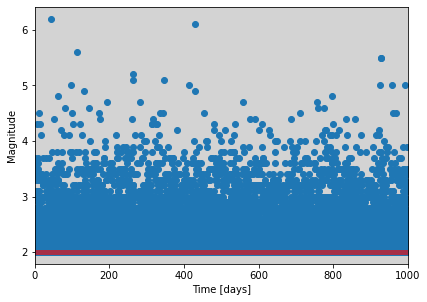

In [29]:
fig3 = plt.figure(figsize=(17/2.54,12/2.54))
ax1 = fig3.add_subplot(111, facecolor='lightgrey')
ax1.scatter(times1, mags1, marker='o')
ax1.axhline(Mmin, c='r', lw=5, alpha=0.6)
ax1.set_ylabel('Magnitude')
ax1.set_xlim(0, 1000)
ax1.set_xlabel('Time [days]')

### Plot the discrete and cumulative magnitude frequency distribution. What is your completeness magnitude? You can use 'cumsum' on the reversed counts to quickly calculate the cumulative distribution

In [30]:
mags = arange(Mmin, 8.0, 0.1)-0.05
mag_points = mags[:-1]+0.05
mag_counts, bes = histogram(mags1, mags)

Text(0.5, 0, 'Magnitude')

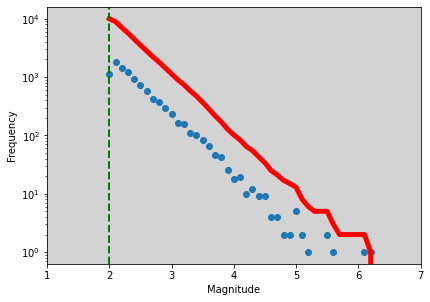

In [31]:
fig4 = plt.figure(figsize=(17/2.54,12/2.54))
ax1 = fig4.add_subplot(111, facecolor='lightgrey')
ax1.semilogy(mag_points, mag_counts, 'o')
ax1.semilogy(mag_points, cumsum(mag_counts[::-1])[::-1] , 'r-', lw=5)
ax1.axvline(Mmin, c='g', lw=2, ls='--')
ax1.set_ylabel('Frequency')
ax1.set_xlim(1.0, 7.0)
ax1.set_xlabel('Magnitude')

### Now calculate the b-value and a-value by maximum likelihood

In [36]:
mco = 2.1
mbin = 0.1
mags_co = mags1[mags1>=2.1]
nbev = len(mags_co)
b_hat = log10(exp(1))/(np.mean(mags_co)-(mco-mbin/2))
b_unc = (2.3*b_hat**2)*np.sqrt(sum((mags-np.mean(mags_co))**2)/(nbev*(nbev-1)))
a_hat = log10(nbev) + b_hat*mco 
print(b_hat, b_unc, a_hat)

0.9920066938978055 0.005857157419720387 6.032066963385105


## The Modified Omori law

### Simulating point process data with a time-varying mean rate is a little more involved. One approach is called 'thinning'. Event times are created at the highest rate expected for a sequence, and then thinned according to the probabilities given by the rate function (in this case, the modified Omori law

### First, define the modified omori law as a function of time from a mainshock

In [37]:
p = 0.98
c = 0.1 #days
k = 100

def mor(t, p, c, k):
    rate = k*(t+c)**-p
    return rate


### Plot a quick figure to show the modified Omori rate as a function of time

Text(0.5, 0, 'Time [Days]')

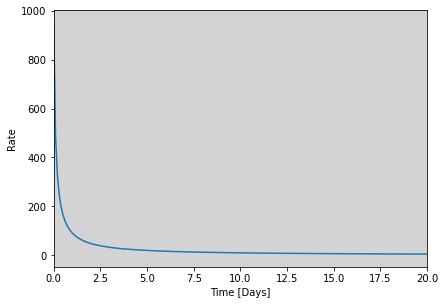

In [38]:
ts = arange(0, 100, 0.1)
rates = mor(ts, p, c, k)

fig5 = plt.figure(figsize=(17/2.54,12/2.54))
ax1 = fig5.add_subplot(111, facecolor='lightgrey')
ax1.plot(ts, rates, '-')
ax1.set_ylabel('Rate')
ax1.set_xlim(0.0, 20.0)
ax1.set_xlabel('Time [Days]')

### The highest aftershock rates will be at t = 0, so we can generate events for 20 days at that rate, and give them all a uniform probability between 0 and 1

In [41]:
max_rate = mor(0, p, c, k)
duration = 20
data2 = expon.rvs(scale=1./max_rate, size=rate*duration)
times2 = cumsum(data2)

while max(times2) < 20:
    times2 = np.hstack((times2, max(times2) + expon.rvs(scale=1./max_rate, size=1)))
    
times2 = times2[times2<=20]

probs2 = uniform.rvs(size=len(times2))

### Plot a figure to show these event times, probabilites, and the probability for inclusion given by the modified Omori law

Text(0.5, 0, 'Time [Days]')

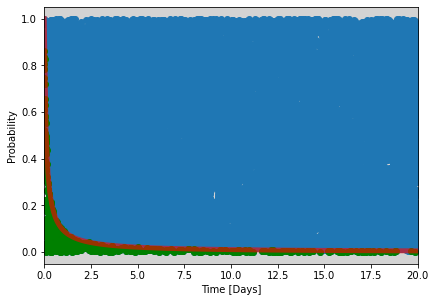

In [42]:
times2_sel = times2[(probs2-mor(times2,p,c,k)/mor(0,p,c,k))<0]
probs2_sel = probs2[(probs2-mor(times2,p,c,k)/mor(0,p,c,k))<0]

fig6 = plt.figure(figsize=(17/2.54,12/2.54))
ax1 = fig6.add_subplot(111, facecolor='lightgrey')
ax1.plot(times2, probs2, 'o')
ax1.plot(times2_sel, probs2_sel, 'og')
ax1.plot(ts, mor(ts,p,c,k)/mor(0,p,c,k),'r-', lw=5, alpha=0.6)
ax1.set_ylabel('Probability')
ax1.set_xlim(0.0, 20.0)
ax1.set_xlabel('Time [Days]')

### Now count and plot the daily earthquake rate and total number of events

In [43]:
days2 = arange(0, 21, 0.1)
day_counts2, bes = histogram(times2_sel, days2)

(0.0, 20.0)

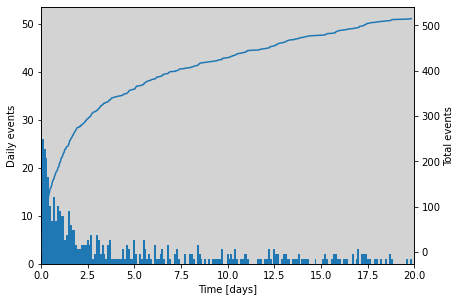

In [44]:
fig7 = plt.figure(figsize=(17/2.54,12/2.54))
ax1 = fig7.add_subplot(111, facecolor='lightgrey')
ax1.bar(days2[:-1], day_counts2, align='center', width = 0.1)
ax1.set_ylabel('Daily events')
ax1.set_xlim(0, 20)
ax2 = ax1.twinx()
ax2.plot(times2_sel, arange(len(times2_sel)))
ax1.set_xlabel('Time [days]')
ax2.set_ylabel('Total events')
ax2.set_xlim(0, 20)